### to tidy up the week 2 code, turn it into nice functions

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' #make sure I'm using the right GPU

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import uproot as ur
import pandas as pd
import atlas_mpl_style as ampl #makes matplotlib follow atlas formal style
ampl.use_atlas_style()

plotpath = '/home/kaelaekd/start_tf/LCStudies/clusters/Plots/'

import sys
sys.path.append('/home/kaelaekd/start_tf/LCStudies')
from  util import resolution_util as ru
from  util import plot_util as pu

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d

In [3]:
# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4] #'image sizes' in phi/eta coords
len_eta = [128, 16, 8, 4, 4, 2]

path = '/fast_scratch/atlas_images/v7/'

branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']

In [4]:
p0_file = ur.open(path+'pi0.root')
p0_tree = p0_file['ClusterTree']
p0 = pd.DataFrame(p0_tree.arrays(expressions = branches, library='np'))

pp_file = ur.open(path+'piplus.root')
pp_tree = pp_file['ClusterTree']
pp = pd.DataFrame(pp_tree.arrays(expressions = branches, library='np')) 

pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT 
p0['clusterEoverCalib'] = p0.clusterE / p0.cluster_ENG_CALIB_TOT

In [25]:
def simple_pi_NN(ppdat_list, p0dat_list, epochs):
    """ Run a simple neural network to distinguish between pi+ and pi0 based on variable input data (ppdat_list
    and p0dat_list) for a given number of training epochs.
    the lists need to be lists of data arrays or dataframe objs - the actual data to be used
    (see run below)
    formats the data, makes the model, trains and tests the model. returns the training history and some
    metrics (change to include other metrics if needed)"""
    
    dim = len(ppdat_list) #get the data dimensions
    
    #define metrics to return
    METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        #tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        #tf.keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve
    ]
    
    #format data and labels
    ppdat = np.column_stack(ppdat_list) 
    p0dat = np.column_stack(p0dat_list)
    dataset = np.append(ppdat, p0dat, axis=0)
    labels = np.append(np.zeros(len(ppdat_list[0])), np.ones(len(p0dat_list[0])))#0 = pp, 1 = p0
    
    print(ppdat.shape, dataset.shape, labels.shape)
    
    #split into training and testing sets
    data_train, data_test, label_train, label_test = train_test_split(dataset, labels, test_size=0.3, random_state=1)
    
    #need to one hot the labels!
    label_train_oh = np_utils.to_categorical(label_train, 2)
    label_test_oh = np_utils.to_categorical(label_test, 2)
    
    print(label_train.shape, label_train_oh.shape, label_train_oh[0])
    
    #define model
    #seems to actually perform better without too many nodes
    model = tf.keras.Sequential([tf.keras.layers.Dense(100, activation='relu', input_dim=dim),
                                 #tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 #tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 #tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(2, kernel_initializer='normal', activation='softmax')]) #needed to specify softmax on last layer (why?)
    
    #compile model
    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), #can't be sparse if using onehot!
                  metrics=METRICS)
    
    #train the model
    history = model.fit(data_train, label_train_oh, epochs=epochs)
    
    print('\n test accuracy:')
    #evaluate it on the test data
    test_results = model.evaluate(data_test,  label_test_oh, verbose=2)
    
    #get some metrics using the test data
    score = model.predict(data_test)
    fpr_pred, tpr_pred, _ = roc_curve(label_test_oh[:,1], score[:,1],drop_intermediate=False)
    auc_pred = auc(fpr_pred, tpr_pred)
    
    return history, fpr_pred, tpr_pred, auc_pred

In [9]:
ppdatlist = (pp.cluster_FIRST_ENG_DENS, pp.cluster_CENTER_MAG, pp.clusterE)
p0datlist = (p0.cluster_FIRST_ENG_DENS, p0.cluster_CENTER_MAG, p0.clusterE)
#need this format for the way my function is set up :)

In [21]:
def metrics_and_plots(hist, FPR, TPR, AUC):
    """ plots training accuracy and loss, an ROC curve, prints out the AUC of the curve, plots how auc changed
    with epoch while training, makes a rejection/efficiency plot, and prints out the rejection at 95% pion 
    efficiency"""
    
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    
    # plot training accuracy
    ax0.set_xlim(-.1,len(hist.history['loss']))
    ax0.plot(hist.history['accuracy'], label='training accuracy', c='xkcd:orange', linewidth=3) 
    ax0.set_xlabel('epoch')
    ax0.set_ylabel('accuracy')
    ax0.legend()
    
    # plot loss during training
    ax1.set_xlim(-.1,len(hist.history['loss']))
    ax1.set_ylim(0.2, .5)
    ax1.semilogy()
    ax1.plot(hist.history['loss'], label = 'training loss', c='xkcd:apricot', linewidth=4) 
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()
     
    #roc curve
    ax2.set_xlim(0,1)
    ax2.set_ylim(0,1)
    ax2.plot(FPR, TPR, c='xkcd:sepia', linewidth=3)
    ax2.set_xlabel('false positive rate')
    ax2.set_ylabel('true positive rate') 
    
    print('AUC:', AUC)
    
    #rejection/efficiency plot
    ax3.set_xlim(0,1)
    ax3.semilogy()
    ax3.set_ylim(0, 1.4e5)
    ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
    ax3.set_xlabel('Efficiency (tpr)') 
    ax3.set_ylabel('Rejection (1/fpr)')
   
    f = interp1d(TPR, 1/FPR)
    
    print('Rejection at 95% efficiency:', f(.95))
    
    #plot auc while training
    plt.figure(figsize=[6,6])
    plt.xlim(0,len(hist.history['auc']))
    plt.plot(hist.history['auc'], c='xkcd:clay brown', linewidth=3)
    plt.xlabel('epoch')
    plt.ylabel('training auc')

(435967, 3) (699858, 3) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/30
15310/15310 [==============================] - 105s 7ms/step - loss: 0.6195 - tp: 172311.4260 - fp: 72680.5693 - tn: 172311.4260 - fn: 72680.5693 - accuracy: 0.6859 - precision: 0.6859 - auc: 0.7689
Epoch 2/30
15310/15310 [==============================] - 106s 7ms/step - loss: 0.4525 - tp: 189709.3725 - fp: 55282.6228 - tn: 189709.3725 - fn: 55282.6228 - accuracy: 0.7722 - precision: 0.7722 - auc: 0.8676
Epoch 3/30
15310/15310 [==============================] - 105s 7ms/step - loss: 0.4344 - tp: 191365.6250 - fp: 53626.3703 - tn: 191365.6250 - fn: 53626.3703 - accuracy: 0.7811 - precision: 0.7811 - auc: 0.8776
Epoch 4/30
15310/15310 [==============================] - 105s 7ms/step - loss: 0.4279 - tp: 192320.9886 - fp: 52671.0067 - tn: 192320.9886 - fn: 52671.0067 - accuracy: 0.7846 - precision: 0.7846 - auc: 0.8800
Epoch 5/30
15310/15310 [==============================] - 104s 7ms/step - loss: 0.4211 - tp: 193

<ipython-input-9-c559d1d6eae3>:35: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1.4e5)
<ipython-input-9-c559d1d6eae3>:36: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)


Rejection at 95% efficiency: 2.696747894094624


<ipython-input-9-c559d1d6eae3>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


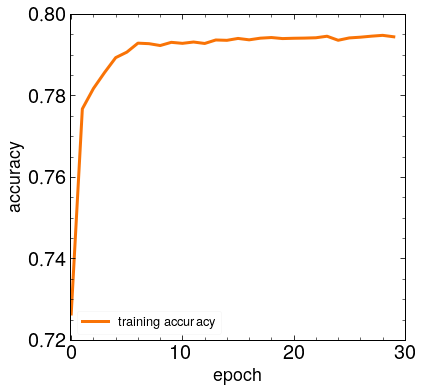

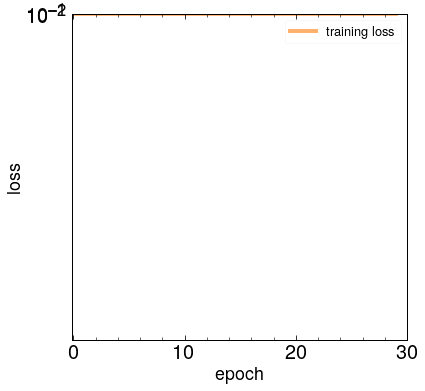

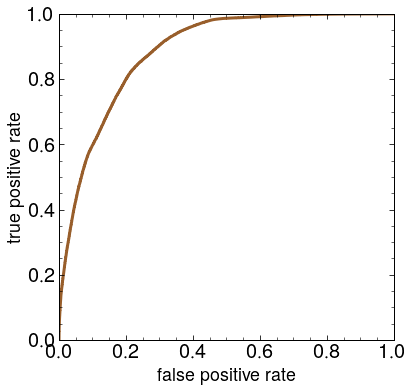

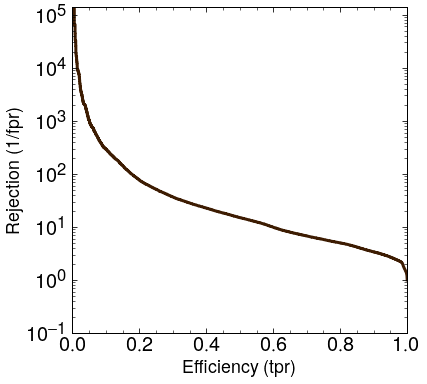

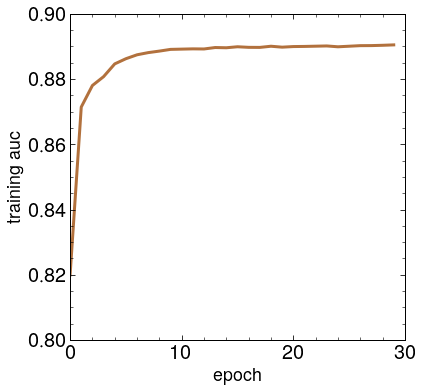

In [10]:
#try some different types; first: dens, depth, E,3 layers x 30 nodes, 30 epochs, don't rerun
hist, FPR, TPR, AUC = simple_pi_NN(ppdatlist, p0datlist, epochs=30) 

metrics_and_plots(hist, FPR, TPR, AUC) #whoops, wrong loss plot

AUC: 0.8852644546905665
Rejection at 95% efficiency: 2.696747894094624


<ipython-input-19-2ce7c0168b57>:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0, 1.4e5)
<ipython-input-19-2ce7c0168b57>:37: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
<ipython-input-19-2ce7c0168b57>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


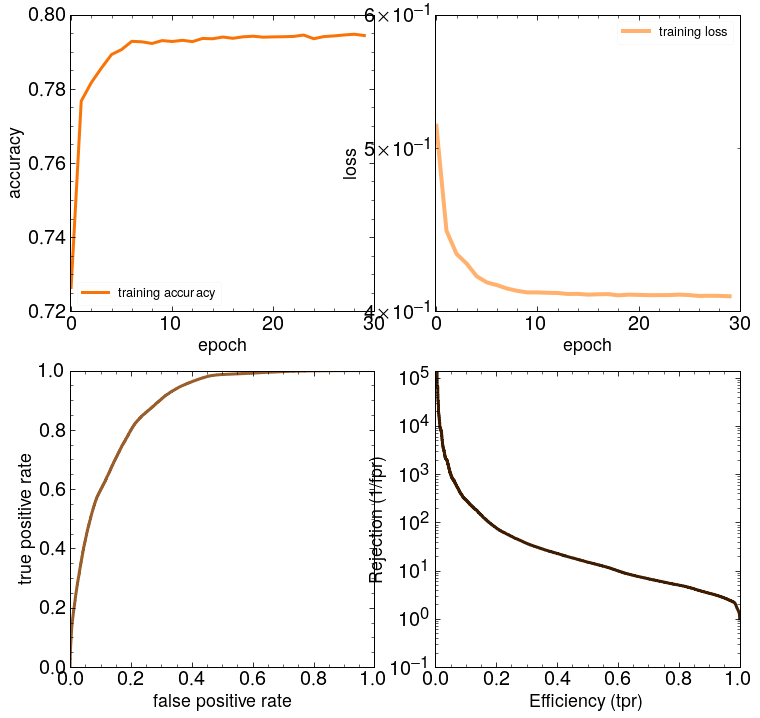

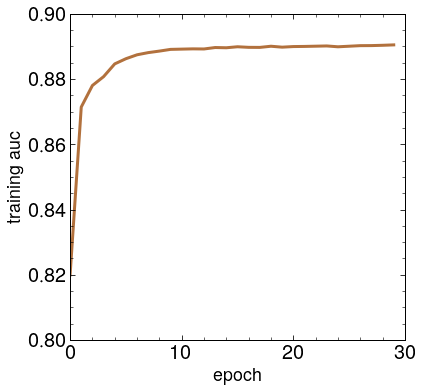

In [20]:
metrics_and_plots(hist, FPR, TPR, AUC)

(435967, 3) (699858, 3) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/20
15310/15310 [==============================] - 116s 7ms/step - loss: 0.5037 - tp: 181239.6002 - fp: 63752.3951 - tn: 181239.6002 - fn: 63752.3951 - accuracy: 0.7233 - precision: 0.7233 - auc: 0.8231
Epoch 2/20
15310/15310 [==============================] - 116s 8ms/step - loss: 0.4187 - tp: 193137.4533 - fp: 51854.5420 - tn: 193137.4533 - fn: 51854.5420 - accuracy: 0.7879 - precision: 0.7879 - auc: 0.8830
Epoch 3/20
15310/15310 [==============================] - 116s 8ms/step - loss: 0.4110 - tp: 194437.3005 - fp: 50554.6948 - tn: 194437.3005 - fn: 50554.6948 - accuracy: 0.7932 - precision: 0.7932 - auc: 0.8880
Epoch 4/20
15310/15310 [==============================] - 121s 8ms/step - loss: 0.4083 - tp: 194966.3300 - fp: 50025.6653 - tn: 194966.3300 - fn: 50025.6653 - accuracy: 0.7959 - precision: 0.7959 - auc: 0.8899
Epoch 5/20
15310/15310 [==============================] - 113s 7ms/step - loss: 0.4053 - tp: 195

<ipython-input-10-2ce7c0168b57>:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0, 1.4e5)
<ipython-input-10-2ce7c0168b57>:37: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
<ipython-input-10-2ce7c0168b57>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


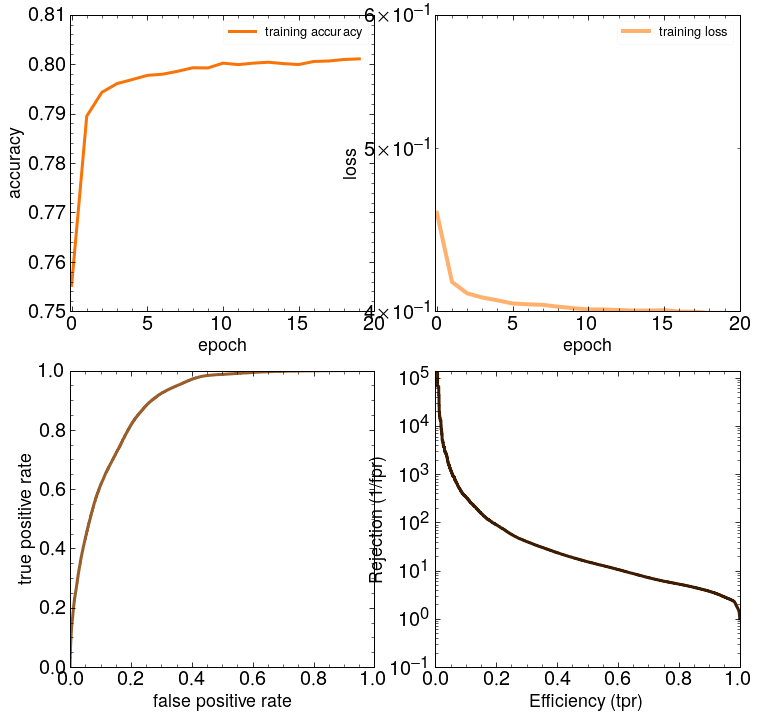

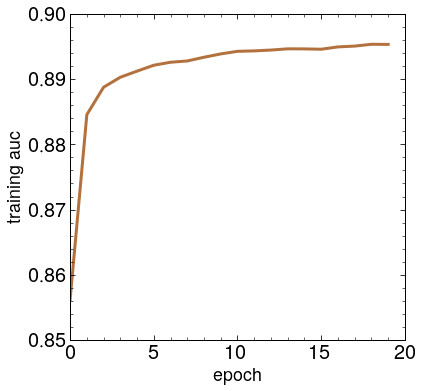

In [11]:
#try 2: dens, depth, E, 10 layers x 30 nodes, 20 epochs, don't rerun

hist, FPR, TPR, AUC = simple_pi_NN(ppdatlist, p0datlist, epochs=20) 

metrics_and_plots(hist, FPR, TPR, AUC) 

(435967, 3) (699858, 3) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/20
15310/15310 [==============================] - 122s 8ms/step - loss: 0.5056 - tp: 180348.6860 - fp: 64643.3093 - tn: 180348.6860 - fn: 64643.3093 - accuracy: 0.7208 - precision: 0.7208 - auc: 0.8199
Epoch 2/20
15310/15310 [==============================] - 120s 8ms/step - loss: 0.4210 - tp: 192887.4793 - fp: 52104.5160 - tn: 192887.4793 - fn: 52104.5160 - accuracy: 0.7867 - precision: 0.7867 - auc: 0.8817
Epoch 3/20
15310/15310 [==============================] - 119s 8ms/step - loss: 0.4185 - tp: 193363.8152 - fp: 51628.1801 - tn: 193363.8152 - fn: 51628.1801 - accuracy: 0.7874 - precision: 0.7874 - auc: 0.8829
Epoch 4/20
15310/15310 [==============================] - 120s 8ms/step - loss: 0.4102 - tp: 194741.2065 - fp: 50250.7888 - tn: 194741.2065 - fn: 50250.7888 - accuracy: 0.7950 - precision: 0.7950 - auc: 0.8886
Epoch 5/20
15310/15310 [==============================] - 118s 8ms/step - loss: 0.4072 - tp: 195

<ipython-input-10-2ce7c0168b57>:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0, 1.4e5)
<ipython-input-10-2ce7c0168b57>:37: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
<ipython-input-10-2ce7c0168b57>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


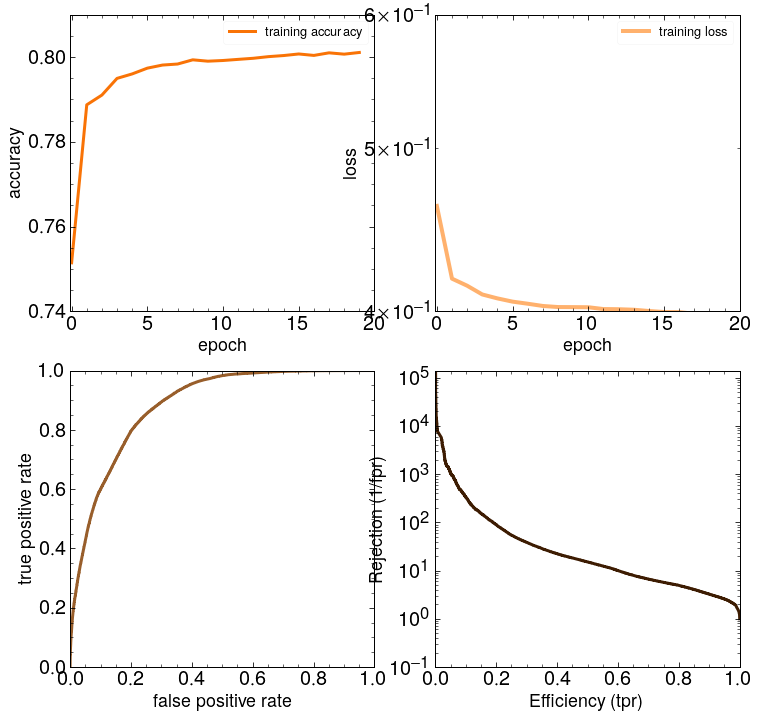

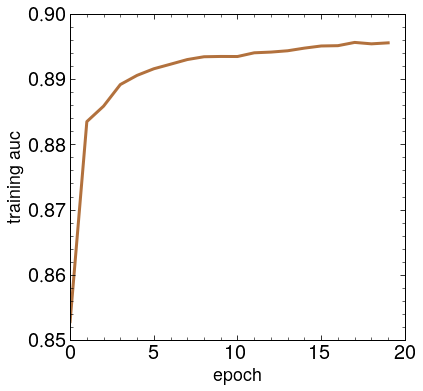

In [13]:
#try 3: dens, depth, E, 10 layers x 100 nodes, 20 epochs, don't rerun

hist3, FPR3, TPR3, AUC3 = simple_pi_NN(ppdatlist, p0datlist, epochs=20) 

metrics_and_plots(hist3, FPR3, TPR3, AUC3) 

(435967, 4) (699858, 4) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/10
15310/15310 [==============================] - 120s 8ms/step - loss: 0.4927 - tp: 182707.9092 - fp: 62284.0861 - tn: 182707.9092 - fn: 62284.0861 - accuracy: 0.7285 - precision: 0.7285 - auc: 0.8276
Epoch 2/10
15310/15310 [==============================] - 114s 7ms/step - loss: 0.4063 - tp: 195416.5556 - fp: 49575.4397 - tn: 195416.5556 - fn: 49575.4397 - accuracy: 0.7969 - precision: 0.7969 - auc: 0.8913
Epoch 3/10
15310/15310 [==============================] - 120s 8ms/step - loss: 0.3983 - tp: 196695.3409 - fp: 48296.6544 - tn: 196695.3409 - fn: 48296.6544 - accuracy: 0.8024 - precision: 0.8024 - auc: 0.8963
Epoch 4/10
15310/15310 [==============================] - 119s 8ms/step - loss: 0.3939 - tp: 197248.7800 - fp: 47743.2153 - tn: 197248.7800 - fn: 47743.2153 - accuracy: 0.8052 - precision: 0.8052 - auc: 0.8988
Epoch 5/10
14495/15310 [===========================>..] - ETA: 6s - loss: 0.3912 - tp: 186922.31

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



15310/15310 [==============================] - 117s 8ms/step - loss: 0.3857 - tp: 198289.3467 - fp: 46702.6486 - tn: 198289.3467 - fn: 46702.6486 - accuracy: 0.8093 - precision: 0.8093 - auc: 0.9034

 test accuracy:
6562/6562 - 38s - loss: 0.3837 - tp: 170613.0000 - fp: 39345.0000 - tn: 170613.0000 - fn: 39345.0000 - accuracy: 0.8126 - precision: 0.8126 - auc: 0.9057
AUC: 0.8997489056121399
Rejection at 95% efficiency: 2.912753326114264


<ipython-input-14-14b9fba1d85e>:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0, 1.4e5)
<ipython-input-14-14b9fba1d85e>:37: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
<ipython-input-14-14b9fba1d85e>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


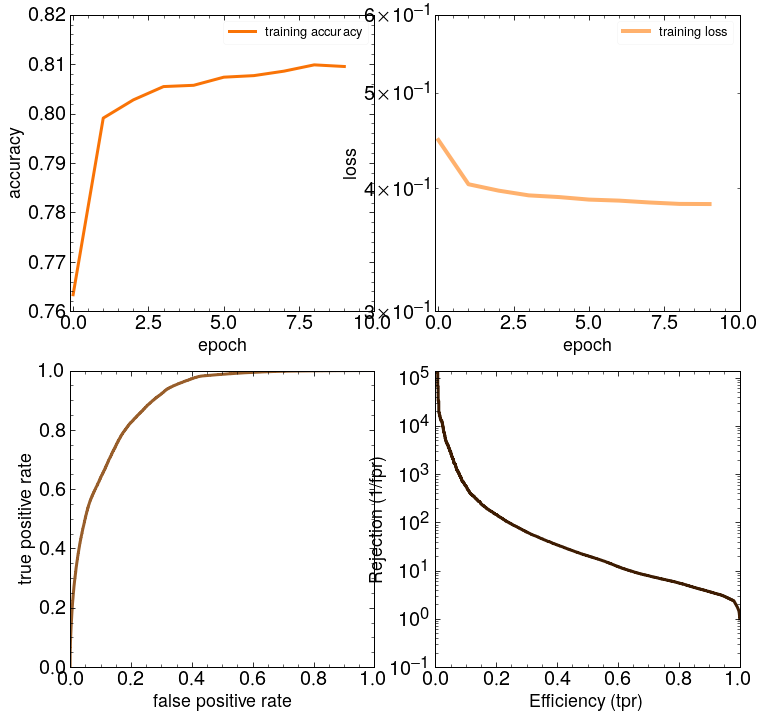

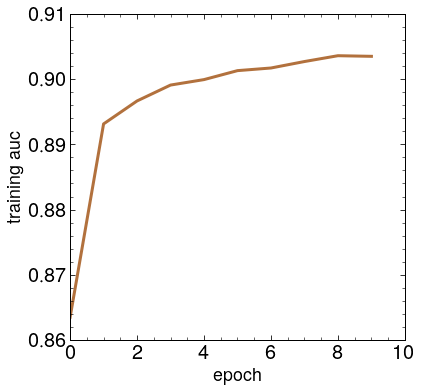

In [15]:
#try 4: dens, depth, E, and pt, 10 layers x 100 nodes, 10 epochs, don't rerun
ppdatlist4 = (pp.cluster_FIRST_ENG_DENS, pp.cluster_CENTER_MAG, pp.clusterE, pp.clusterPt)
p0datlist4 = (p0.cluster_FIRST_ENG_DENS, p0.cluster_CENTER_MAG, p0.clusterE, p0.clusterPt)

#will try adding the different data one each and see which ones make it better, then combine all the good ones
hist4, FPR4, TPR4, AUC4 = simple_pi_NN(ppdatlist4, p0datlist4, epochs=10) 

metrics_and_plots(hist4, FPR4, TPR4, AUC4) #seems like this helps a bit

(435967, 4) (699858, 4) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/10
15310/15310 [==============================] - 118s 8ms/step - loss: 0.4536 - tp: 192930.2205 - fp: 52061.7748 - tn: 192930.2205 - fn: 52061.7748 - accuracy: 0.7727 - precision: 0.7727 - auc: 0.8634
Epoch 2/10
 4596/15310 [========>.....................] - ETA: 1:20 - loss: 0.3714 - tp: 60520.2363 - fp: 13031.7637 - tn: 60520.2363 - fn: 13031.7637 - accuracy: 0.8223 - precision: 0.8223 - auc: 0.9129

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



15310/15310 [==============================] - 121s 8ms/step - loss: 0.3568 - tp: 203152.6593 - fp: 41839.3360 - tn: 203152.6593 - fn: 41839.3360 - accuracy: 0.8291 - precision: 0.8291 - auc: 0.9193
Epoch 5/10
15310/15310 [==============================] - 122s 8ms/step - loss: 0.3534 - tp: 203550.6358 - fp: 41441.3595 - tn: 203550.6358 - fn: 41441.3595 - accuracy: 0.8311 - precision: 0.8311 - auc: 0.9210
Epoch 6/10
15310/15310 [==============================] - 120s 8ms/step - loss: 0.3538 - tp: 203656.2297 - fp: 41335.7656 - tn: 203656.2297 - fn: 41335.7656 - accuracy: 0.8312 - precision: 0.8312 - auc: 0.9210
Epoch 7/10
15310/15310 [==============================] - 117s 8ms/step - loss: 0.3534 - tp: 203761.1267 - fp: 41230.8686 - tn: 203761.1267 - fn: 41230.8686 - accuracy: 0.8315 - precision: 0.8315 - auc: 0.9211
Epoch 8/10
15310/15310 [==============================] - 122s 8ms/step - loss: 0.3512 - tp: 203988.4664 - fp: 41003.5289 - tn: 203988.4664 - fn: 41003.5289 - accuracy: 0.

<ipython-input-14-14b9fba1d85e>:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0, 1.4e5)
<ipython-input-14-14b9fba1d85e>:37: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
<ipython-input-14-14b9fba1d85e>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


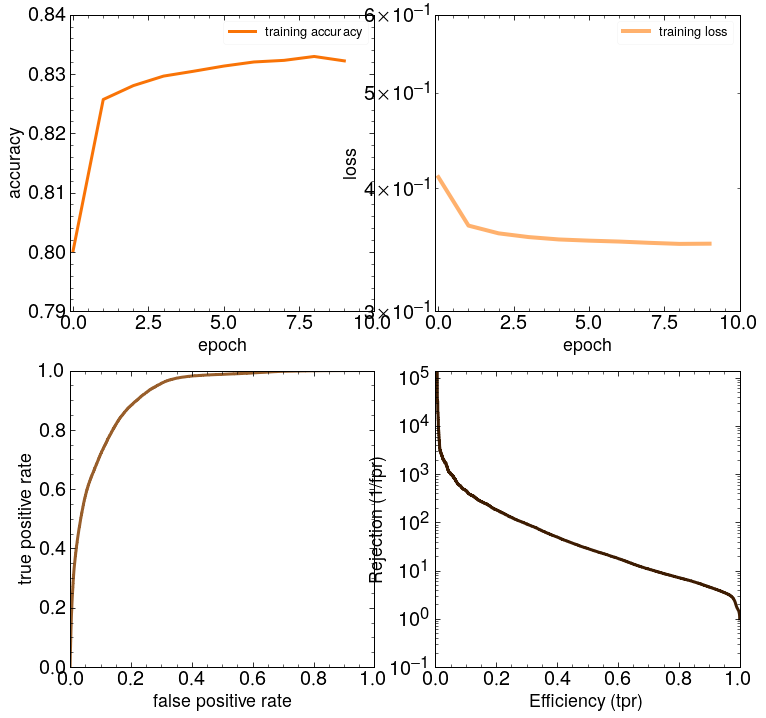

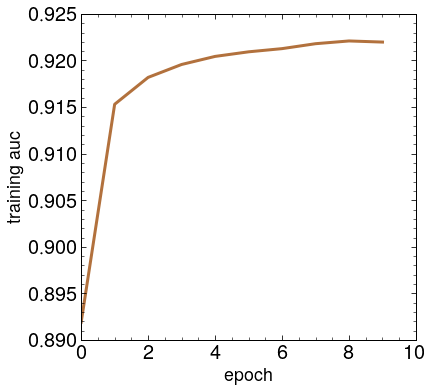

In [16]:
#try 5: dens, depth, E, and number of cells, 10 layers x 100 nodes, 10 epochs, don't rerun
ppdatlist5 = (pp.cluster_FIRST_ENG_DENS, pp.cluster_CENTER_MAG, pp.clusterE, pp.cluster_nCells)
p0datlist5 = (p0.cluster_FIRST_ENG_DENS, p0.cluster_CENTER_MAG, p0.clusterE, p0.cluster_nCells)

#will try adding the different data one each and see which ones make it better, then combine all the good ones
hist5, FPR5, TPR5, AUC5 = simple_pi_NN(ppdatlist5, p0datlist5, epochs=10) 

metrics_and_plots(hist5, FPR5, TPR5, AUC5) #definitely helps!

(435967, 4) (699858, 4) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/10
15310/15310 [==============================] - 119s 8ms/step - loss: 0.5059 - tp: 180228.5467 - fp: 64763.4486 - tn: 180228.5467 - fn: 64763.4486 - accuracy: 0.7214 - precision: 0.7214 - auc: 0.8208
Epoch 2/10
15310/15310 [==============================] - 122s 8ms/step - loss: 0.4222 - tp: 192818.5078 - fp: 52173.4875 - tn: 192818.5078 - fn: 52173.4875 - accuracy: 0.7858 - precision: 0.7858 - auc: 0.8807
Epoch 3/10
15310/15310 [==============================] - 109s 7ms/step - loss: 0.4162 - tp: 193889.5024 - fp: 51102.4928 - tn: 193889.5024 - fn: 51102.4928 - accuracy: 0.7907 - precision: 0.7907 - auc: 0.8849
Epoch 4/10
15310/15310 [==============================] - 98s 6ms/step - loss: 0.4109 - tp: 194640.1142 - fp: 50351.8811 - tn: 194640.1142 - fn: 50351.8811 - accuracy: 0.7937 - precision: 0.7937 - auc: 0.8884
Epoch 5/10
15310/15310 [==============================] - 95s 6ms/step - loss: 0.4088 - tp: 19487

<ipython-input-14-14b9fba1d85e>:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0, 1.4e5)
<ipython-input-14-14b9fba1d85e>:37: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
<ipython-input-14-14b9fba1d85e>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


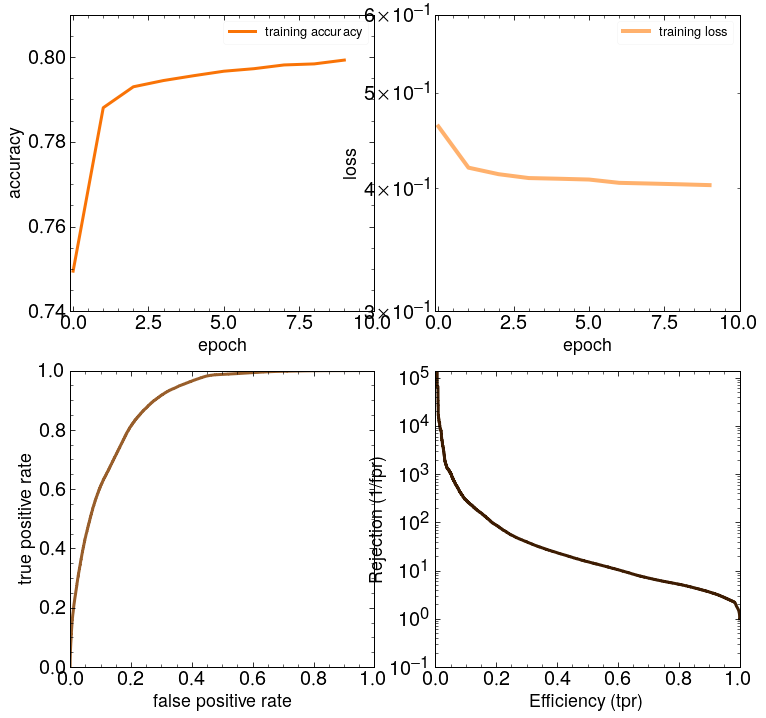

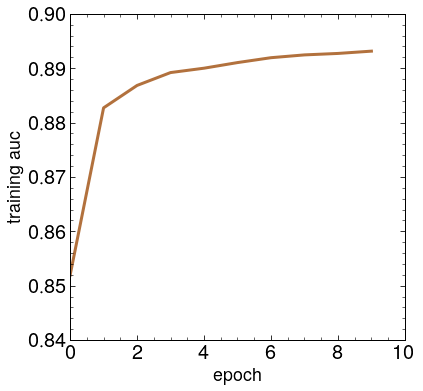

In [17]:
#try 6: dens, depth, E, and eta, 10 layers x 100 nodes, 10 epochs, don't rerun
ppdatlist6 = (pp.cluster_FIRST_ENG_DENS, pp.cluster_CENTER_MAG, pp.clusterE, pp.clusterEta)
p0datlist6 = (p0.cluster_FIRST_ENG_DENS, p0.cluster_CENTER_MAG, p0.clusterE, p0.clusterEta)

#will try adding the different data one each and see which ones make it better, then combine all the good ones
hist6, FPR6, TPR6, AUC6 = simple_pi_NN(ppdatlist6, p0datlist6, epochs=10) 

metrics_and_plots(hist6, FPR6, TPR6, AUC6) #doesn't seem to help! interesting. won't keep this one

(435967, 4) (699858, 4) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/10
15310/15310 [==============================] - 105s 7ms/step - loss: 0.4509 - tp: 193348.8986 - fp: 51643.0967 - tn: 193348.8986 - fn: 51643.0967 - accuracy: 0.7610 - precision: 0.7610 - auc: 0.8586
Epoch 2/10
15310/15310 [==============================] - 103s 7ms/step - loss: 0.2999 - tp: 212164.2464 - fp: 32827.7489 - tn: 212164.2464 - fn: 32827.7489 - accuracy: 0.8654 - precision: 0.8654 - auc: 0.9449
Epoch 3/10
15310/15310 [==============================] - 96s 6ms/step - loss: 0.2865 - tp: 213978.9306 - fp: 31013.0647 - tn: 213978.9306 - fn: 31013.0647 - accuracy: 0.8733 - precision: 0.8733 - auc: 0.9498
Epoch 4/10
15310/15310 [==============================] - 97s 6ms/step - loss: 0.2832 - tp: 214532.0738 - fp: 30459.9215 - tn: 214532.0738 - fn: 30459.9215 - accuracy: 0.8751 - precision: 0.8751 - auc: 0.9509
Epoch 5/10
15310/15310 [==============================] - 97s 6ms/step - loss: 0.2821 - tp: 214882

<ipython-input-14-14b9fba1d85e>:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0, 1.4e5)
<ipython-input-14-14b9fba1d85e>:37: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
<ipython-input-14-14b9fba1d85e>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


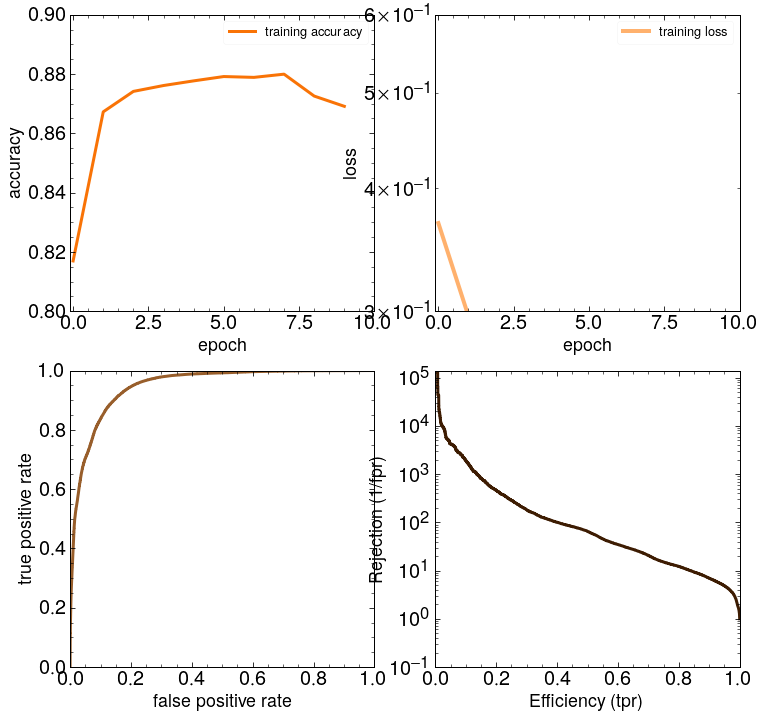

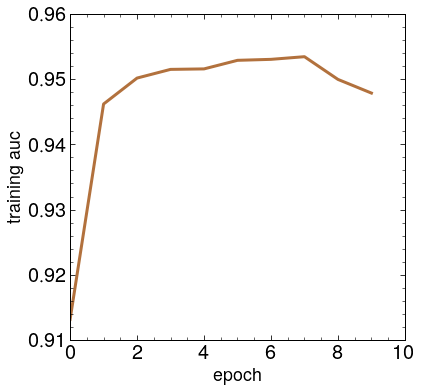

In [18]:
#try 7: dens, depth, E, and out of cluster cells, 10 layers x 100 nodes, 10 epochs, don't rerun
ppdatlist7 = (pp.cluster_FIRST_ENG_DENS, pp.cluster_CENTER_MAG, pp.clusterE, pp.cluster_ENG_CALIB_OUT_T)
p0datlist7 = (p0.cluster_FIRST_ENG_DENS, p0.cluster_CENTER_MAG, p0.clusterE, p0.cluster_ENG_CALIB_OUT_T)

#will try adding the different data one each and see which ones make it better, then combine all the good ones
hist7, FPR7, TPR7, AUC7 = simple_pi_NN(ppdatlist7, p0datlist7, epochs=10) 

metrics_and_plots(hist7, FPR7, TPR7, AUC7) #oh damn this one really helps!!

(435967, 4) (699858, 4) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/10
15310/15310 [==============================] - 98s 6ms/step - loss: 0.4587 - tp: 190441.8060 - fp: 54550.1893 - tn: 190441.8060 - fn: 54550.1893 - accuracy: 0.7578 - precision: 0.7578 - auc: 0.8561
Epoch 2/10
15310/15310 [==============================] - 98s 6ms/step - loss: 0.3607 - tp: 203609.0463 - fp: 41382.9490 - tn: 203609.0463 - fn: 41382.9490 - accuracy: 0.8306 - precision: 0.8306 - auc: 0.9185
Epoch 3/10
15310/15310 [==============================] - 117s 8ms/step - loss: 0.3515 - tp: 204656.5110 - fp: 40335.4843 - tn: 204656.5110 - fn: 40335.4843 - accuracy: 0.8349 - precision: 0.8349 - auc: 0.9224
Epoch 4/10
15310/15310 [==============================] - 113s 7ms/step - loss: 0.3472 - tp: 205202.3028 - fp: 39789.6925 - tn: 205202.3028 - fn: 39789.6925 - accuracy: 0.8376 - precision: 0.8376 - auc: 0.9244
Epoch 5/10
15310/15310 [==============================] - 122s 8ms/step - loss: 0.3436 - tp: 20588

<ipython-input-14-14b9fba1d85e>:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0, 1.4e5)
<ipython-input-14-14b9fba1d85e>:37: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
<ipython-input-14-14b9fba1d85e>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


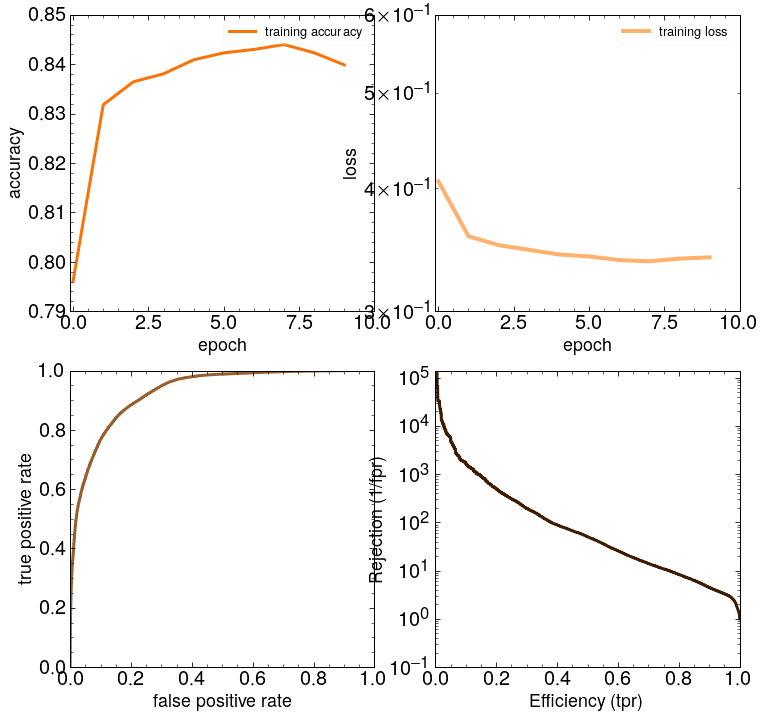

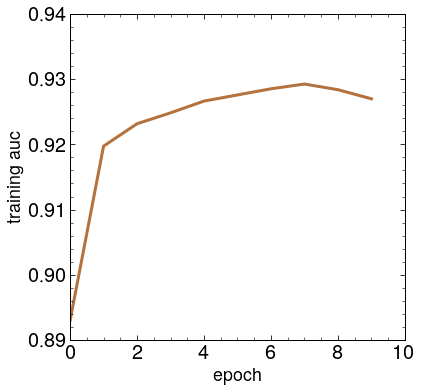

In [19]:
#try 8: dens, depth, E, and dead cells, 10 layers x 100 nodes, 10 epochs, don't rerun
ppdatlist8 = (pp.cluster_FIRST_ENG_DENS, pp.cluster_CENTER_MAG, pp.clusterE, pp.cluster_ENG_CALIB_DEAD_TOT)
p0datlist8 = (p0.cluster_FIRST_ENG_DENS, p0.cluster_CENTER_MAG, p0.clusterE, p0.cluster_ENG_CALIB_DEAD_TOT)

#will try adding the different data one each and see which ones make it better, then combine all the good ones
hist8, FPR8, TPR8, AUC8 = simple_pi_NN(ppdatlist8, p0datlist8, epochs=10) 

metrics_and_plots(hist8, FPR8, TPR8, AUC8)  #this helps too!

(435967, 7) (699858, 7) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/30
15310/15310 [==============================] - 120s 8ms/step - loss: 0.3763 - tp: 207124.7392 - fp: 37867.2561 - tn: 207124.7392 - fn: 37867.2561 - accuracy: 0.8214 - precision: 0.8214 - auc: 0.9064
Epoch 2/30
15310/15310 [==============================] - 120s 8ms/step - loss: 0.2568 - tp: 219167.2241 - fp: 25824.7712 - tn: 219167.2241 - fn: 25824.7712 - accuracy: 0.8936 - precision: 0.8936 - auc: 0.9604
Epoch 3/30
15310/15310 [==============================] - 118s 8ms/step - loss: 0.2415 - tp: 220711.3264 - fp: 24280.6689 - tn: 220711.3264 - fn: 24280.6689 - accuracy: 0.9005 - precision: 0.9005 - auc: 0.9644
Epoch 4/30
15310/15310 [==============================] - 117s 8ms/step - loss: 0.2397 - tp: 220759.8905 - fp: 24232.1048 - tn: 220759.8905 - fn: 24232.1048 - accuracy: 0.9007 - precision: 0.9007 - auc: 0.9649
Epoch 5/30
15310/15310 [==============================] - 119s 8ms/step - loss: 0.2375 - tp: 221

<ipython-input-21-6d3b4938e14b>:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0, 1.4e5)
<ipython-input-21-6d3b4938e14b>:37: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
<ipython-input-21-6d3b4938e14b>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


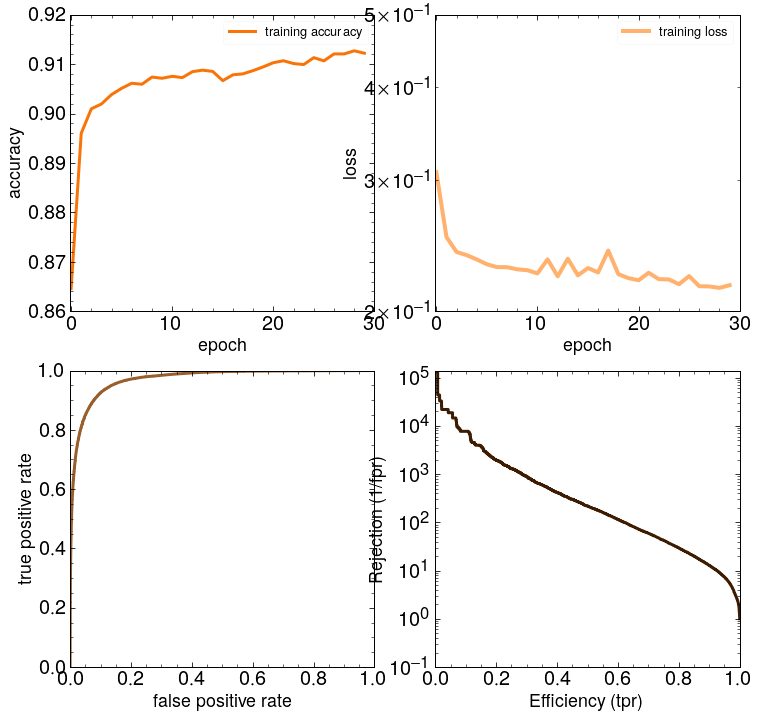

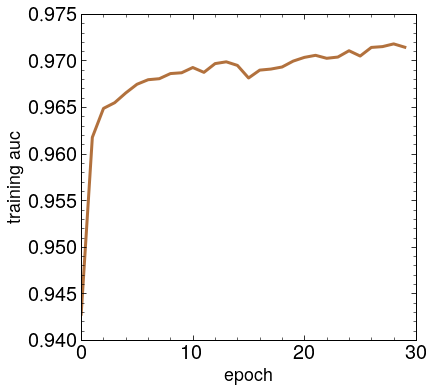

In [22]:
#try 9: dens, depth, E, and all the other working ones, 10 layers x 100 nodes, 30 epochs, don't rerun
ppdatlist_new = (pp.cluster_FIRST_ENG_DENS, pp.cluster_CENTER_MAG, pp.clusterE, pp.clusterPt, pp.cluster_nCells, pp.cluster_ENG_CALIB_OUT_T, pp.cluster_ENG_CALIB_DEAD_TOT)
p0datlist_new = (p0.cluster_FIRST_ENG_DENS, p0.cluster_CENTER_MAG, p0.clusterE, p0.clusterPt, p0.cluster_nCells, p0.cluster_ENG_CALIB_OUT_T, p0.cluster_ENG_CALIB_DEAD_TOT)

#will try adding the different data one each and see which ones make it better, then combine all the good ones
hist9, FPR9, TPR9, AUC9 = simple_pi_NN(ppdatlist_new, p0datlist_new, epochs=30) 

metrics_and_plots(hist9, FPR9, TPR9, AUC9) 

(435967, 7) (699858, 7) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/50
15310/15310 [==============================] - 123s 8ms/step - loss: 0.3870 - tp: 206357.9234 - fp: 38634.0719 - tn: 206357.9234 - fn: 38634.0719 - accuracy: 0.8146 - precision: 0.8146 - auc: 0.8992
Epoch 2/50
15310/15310 [==============================] - 125s 8ms/step - loss: 0.2595 - tp: 218881.9762 - fp: 26110.0191 - tn: 218881.9762 - fn: 26110.0191 - accuracy: 0.8929 - precision: 0.8929 - auc: 0.9594
Epoch 3/50
15310/15310 [==============================] - 128s 8ms/step - loss: 0.2490 - tp: 220157.0725 - fp: 24834.9228 - tn: 220157.0725 - fn: 24834.9228 - accuracy: 0.8984 - precision: 0.8984 - auc: 0.9630
Epoch 4/50
15310/15310 [==============================] - 128s 8ms/step - loss: 0.2405 - tp: 220727.0991 - fp: 24264.8962 - tn: 220727.0991 - fn: 24264.8962 - accuracy: 0.9009 - precision: 0.9009 - auc: 0.9650
Epoch 5/50
15310/15310 [==============================] - 127s 8ms/step - loss: 0.2362 - tp: 221

<ipython-input-21-6d3b4938e14b>:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0, 1.4e5)
<ipython-input-21-6d3b4938e14b>:37: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
<ipython-input-21-6d3b4938e14b>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


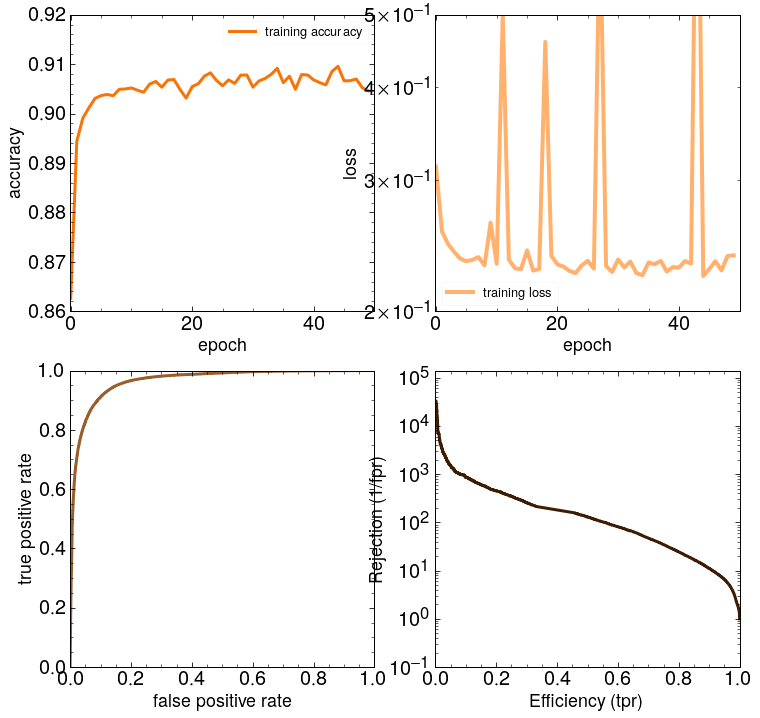

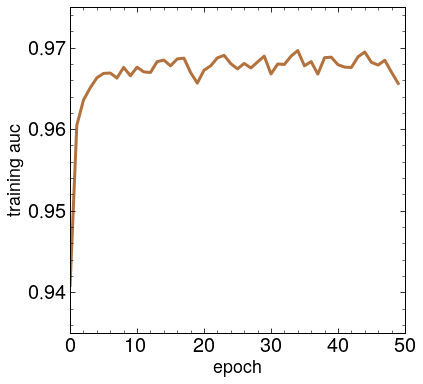

In [24]:
#try 10: dens, depth, E, and other working ones, 10 layers x 100 nodes, 50 epochs, try some dropout layers! don't rerun
hist10, FPR10, TPR10, AUC10 = simple_pi_NN(ppdatlist_new, p0datlist_new, epochs=50) 

metrics_and_plots(hist10, FPR10, TPR10, AUC10) #interesting!!! its not better with dropout layers!

(435967, 7) (699858, 7) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/50
15310/15310 [==============================] - 107s 7ms/step - loss: 0.3652 - tp: 208439.6805 - fp: 36552.3148 - tn: 208439.6805 - fn: 36552.3148 - accuracy: 0.8275 - precision: 0.8275 - auc: 0.9119
Epoch 2/50
15310/15310 [==============================] - 106s 7ms/step - loss: 0.2536 - tp: 219438.4624 - fp: 25553.5329 - tn: 219438.4624 - fn: 25553.5329 - accuracy: 0.8953 - precision: 0.8953 - auc: 0.9609
Epoch 3/50
15310/15310 [==============================] - 104s 7ms/step - loss: 0.2458 - tp: 220377.7957 - fp: 24614.1996 - tn: 220377.7957 - fn: 24614.1996 - accuracy: 0.8992 - precision: 0.8992 - auc: 0.9632
Epoch 4/50
15310/15310 [==============================] - 104s 7ms/step - loss: 0.2398 - tp: 220848.0910 - fp: 24143.9043 - tn: 220848.0910 - fn: 24143.9043 - accuracy: 0.9015 - precision: 0.9015 - auc: 0.9649
Epoch 5/50
15310/15310 [==============================] - 109s 7ms/step - loss: 0.2378 - tp: 221

<ipython-input-21-6d3b4938e14b>:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0, 1.4e5)
<ipython-input-21-6d3b4938e14b>:37: RuntimeWarning: divide by zero encountered in true_divide
  ax3.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
<ipython-input-21-6d3b4938e14b>:41: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


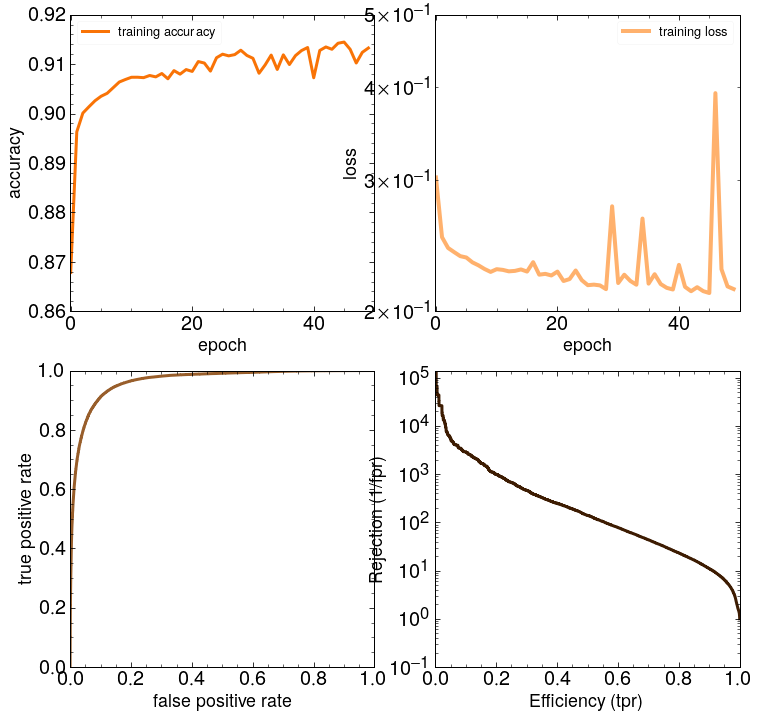

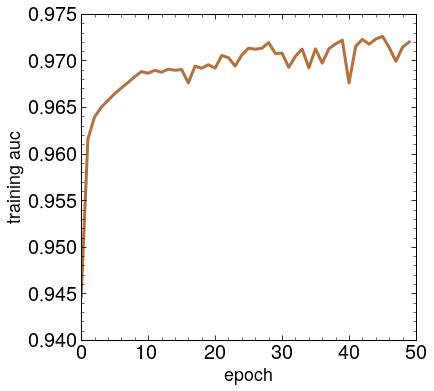

In [26]:
#no dropout, even more regular layers
hist11, FPR11, TPR11, AUC11 = simple_pi_NN(ppdatlist_new, p0datlist_new, epochs=50) 

metrics_and_plots(hist11, FPR11, TPR11, AUC11)